엑셀 파일 -> 파인튜닝 가능 jsonl 파일로

In [ ]:
import json

df_conv = pd.read_excel(file_path)
# Prepare the data for conversion to JSONL
json_list = []

for index, row in df_conv.iterrows():
    message = {
        "messages": [
            {"role": "system", "content": row['System content']},
            {"role": "user", "content": row['User content']},
            {"role": "assistant", "content": row['Assistant content']}
        ]
    }
    json_list.append(json.dumps(message, ensure_ascii=False))

# Define the output file path
output_file_path = '/mnt/data/finetune_sum.jsonl'

# Save the JSONL data to a file with utf-8-sig encoding
with open(output_file_path, 'w', encoding='utf-8-sig') as f:
    for item in json_list:
        f.write(item + '\n')

output_file_path

In [ ]:
messages = [
    [{"role": "user", "content": question}] for question in questions
]

In [ ]:
print(messages)

[[{'role': 'user', 'content': '하는 진단을 받아 수술이 필요해요'}]]


[
      {"role": "user", "content": "하는 진단을 받아 수술이 필요해요"},
      {"role": "user", "content": "고형주가 임금을 지급하지 않아서 소송을 고려하고 있어요 "},
            ]

In [ ]:
# 필요한 라이브러리 임포트
from transformers import BertModel, BertTokenizerFast
from torch.nn.functional import cosine_similarity
import re

# 토크나이저와 모델 로딩
tokenizer_bert = BertTokenizerFast.from_pretrained("kykim/bert-kor-base")
model_bert = BertModel.from_pretrained("kykim/bert-kor-base")

In [ ]:
# SER 측정에 사용할 함수들
def preprocess_text(text):
    """Remove punctuation and spaces from the text."""
    return re.sub(r'[,\.\s]', '', text)

def calculate_levenshtein_distance(s1, s2):
    """Levenshtein distance between two strings."""
    if len(s1) > len(s2):
        s1, s2 = s2, s1

    distances = range(len(s1) + 1)
    for index2, char2 in enumerate(s2):
        new_distances = [index2 + 1]
        for index1, char1 in enumerate(s1):
            if char1 == char2:
                new_distances.append(distances[index1])
            else:
                new_distances.append(1 + min((distances[index1], distances[index1 + 1], new_distances[-1])))
        distances = new_distances
    return distances[-1]

def calculate_ser(original_text, corrected_text):
    """Calculate the Syllable Error Rate (SER) between the original and corrected texts."""
    # Preprocess the texts to remove punctuation and spaces
    original_text = preprocess_text(original_text)
    corrected_text = preprocess_text(corrected_text)

    levenshtein_distance = calculate_levenshtein_distance(original_text, corrected_text)
    total_syllables = len(original_text)
    ser = levenshtein_distance / total_syllables
    return ser

In [ ]:
# 처리할 문장들
original_text = "간염 진단을 받아 수술이 필요해요."
stt_output = questions[0]
corrected_text = response.choices[0].message.content

contents = [original_text, stt_output, corrected_text]

In [ ]:
print(contents)

['간염 진단을 받아 수술이 필요해요.', '하는 진단을 받아 수술이 필요해요', '의학적 진단을 받아 수술이 필요해요.']


In [ ]:
# 문장들을 인코딩하고 모델을 통해 임베딩 추출
encoded_contents = [tokenizer_bert.encode_plus(content, return_tensors='pt', max_length=512, truncation=True, padding='max_length') for content in contents]
embeddings = [model_bert(**encoded_input).last_hidden_state[:,0,:] for encoded_input in encoded_contents]  # `CLS` 토큰의 출력을 사용

# SER 유사도 계산
ser_1_2 = calculate_ser(contents[0], contents[1])
ser_1_3 = calculate_ser(contents[0], contents[2])
# 코사인 유사도 계산
similarity_1_2 = cosine_similarity(embeddings[0], embeddings[1])
similarity_1_3 = cosine_similarity(embeddings[0], embeddings[2])

# 결과 출력
print("SER between Original and STT Output:\t\t", ser_1_2)
print("SER between Original and Corrected Text:\t\t", ser_1_3)
print("Cosine Similarity between Original and STT Output:\t", similarity_1_2.item())
print("Cosine Similarity between Original and Corrected Text:\t", similarity_1_3.item())

SER between Original and STT Output:		 0.0
SER between Original and Corrected Text:		 0.0
Cosine Similarity between Original and STT Output:	 1.0000001192092896
Cosine Similarity between Original and Corrected Text:	 0.9314560294151306


In [ ]:
def calculate_embeddings_and_similarities(contents):
  # 문장들을 인코딩하고 모델을 통해 임베딩 추출
  encoded_contents = [tokenizer_bert.encode_plus(content, return_tensors='pt', max_length=512, truncation=True, padding='max_length') for content in contents]
  embeddings = [model_bert(**encoded_input).last_hidden_state[:,0,:] for encoded_input in encoded_contents]  # `CLS` 토큰의 출력을 사용

  # SER 유사도 계산
  ser_1_2 = calculate_ser(contents[0], contents[1])
  ser_1_3 = calculate_ser(contents[0], contents[2])

  # 코사인 유사도 계산
  similarity_1_2 = cosine_similarity(embeddings[0], embeddings[1])
  similarity_1_3 = cosine_similarity(embeddings[0], embeddings[2])

  return ser_1_2, ser_1_3, similarity_1_2.item(), similarity_1_3.item()

여기부터


In [ ]:
!pip install OpenAI

In [ ]:
import pandas as pd

In [ ]:
def add_data(df, original_text, stt_output, corrected_text, ser_ori_stt, ser_ori_cor, cosine_ori_stt, cosine_ori_cor):
    new_data = {
        'original_text': [original_text],
        'stt_output': [stt_output],
        'corrected_text': [corrected_text],
        'SER(ori, STT)': [ser_ori_stt],
        'SER(ori, Cor)': [ser_ori_cor],
        'Cosine(Ori, STT)': [cosine_ori_stt],
        'Cosine(ori, Cor)': [cosine_ori_cor]
    }
    new_df = pd.DataFrame(new_data)
    df = pd.concat([df, new_df], ignore_index=True)
    return df

In [ ]:
df = pd.DataFrame(columns=[
    'original_text',
    'stt_output',
    'corrected_text',
    'SER(ori, STT)',
    'SER(ori, Cor)',
    'Cosine(Ori, STT)',
    'Cosine(ori, Cor)'
])
df

,original_text,stt_output,corrected_text,"SER(ori, STT)","SER(ori, Cor)","Cosine(Ori, STT)","Cosine(ori, Cor)"


In [ ]:
import pandas as pd

# 엑셀 파일 경로
file_path = '/content/test_data.xlsx'

# 엑셀 파일을 읽어 데이터프레임으로 구성
df_data = pd.read_excel(file_path)

# 'user_content'와 'assistant_content' 컬럼의 데이터를 각각 리스트로 저장
questions = df_data['User content'].tolist()
origins = df_data['Assistant content'].tolist()

# 결과 출력
print("Questions:", questions)
print("Origin:", origins)

Questions: ['가족 폭력 문제로 인해 보호 명령을 받고 싶어요', '가족폭력 문제로 인해 보호 명령을 받고 싶어요', '가족폭력 문제로 인해 보호 명령을 받고 싶어요.', '가족폭력 문제로 인해 명령을 받고 싶어요 ', '간양 진단을 받아 수술이 필요해요 ', '간염 진단을 받아 수술이 필요해요', '하는 진단을 받아 수술이 필요해요', '안양 진단을 받아 수술이 필요해요', '고형주가 임금을 지급하지 않아서 소송을 고려하고 있어요 ', '고용주가 임금을 지급하지 않아서 고려하고 있어요', '고용주가 임금을 지급하지 않아서 소송을 그리하고 있어요.', '고용주가 임금을 지급하지 않아서 소송을 고려하고 있어요', '고혈압 때문에 걱정이에요', '고혈압 때문에 걱정이에요', '고혈압 때문에 걱정이에요', '고혈압 때문에 걱정이에요', '관절염 때문에 일하기가 힘들어요', '관절염 때문에 일하기가 힘들어', '관절염 때문에 일 하기가 힘들어요', '관절염 때문에 일 하기가 힘들어요', '단방비가 부담돼요', '난방비가 부담되어', '난방비가 부담되어', '난방비가 부담돼요', '남망 시설이 고장 났어요', '남방식 노래 고장 났어요', '안방 스토리 고장 났어요', '난방시설이 고장 났어요', '노숙자인데 임시 주고 지원이 필요해요', '노숙자인데 임시주거 지원이 필요해요', '노숙자인데 임시주거 지원이 필요해요', '노숙자인데 임시주거 지원이 필요해요', '가보나 가져는데 경제적 지원이 필요합니다', '다문화가정 아닌데 경제적 지원이 필요합니다', '아무나 과정인데 경제적 지원이 필요합니다.', '다문화가정인데 경제적 지원이 필요합니다', '당교 병이심해요', '당뇨병이 심해요', '당뇨병 심해요', '당뇨병 심해요', '백내장이 심해지고 있어요 ', '백내장에 심해지고 있어요', '백내장이 심해지고 있어요', '백내장에 심해지고', '범죄 피해자로서 피해 보상 청구 지원이 필요합니다', '범죄피해자로서 피해보상청구 조언이 필요합니다', '언제 피해자로서

In [ ]:
messages = [
    [{"role": "user", "content": question}] for question in questions
]

In [ ]:
from openai import OpenAI
key = "" # API KEY

In [ ]:
for message, origin, question in zip(messages, origins, questions):
  response = client.chat.completions.create(
  model="ft:gpt-3.5-turbo-1106:personal::9EdV2QBZ",
  messages= message,
  temperature=1,
  max_tokens=50,
  top_p=1,
  frequency_penalty=0,
  presence_penalty=0,
  stop=["\n\n"]
)
  original_text = origin
  stt_output = question
  corrected_text = response.choices[0].message.content
  contents = [original_text, stt_output, corrected_text]

  # 문장들을 인코딩하고 모델을 통해 임베딩 추출
  encoded_contents = [tokenizer_bert.encode_plus(content, return_tensors='pt', max_length=512, truncation=True, padding='max_length') for content in contents]
  embeddings = [model_bert(**encoded_input).last_hidden_state[:,0,:] for encoded_input in encoded_contents]  # `CLS` 토큰의 출력을 사용

  # SER 유사도 계산
  ser_1_2 = calculate_ser(contents[0], contents[1])
  ser_1_3 = calculate_ser(contents[0], contents[2])
  # 코사인 유사도 계산
  similarity_1_2 = cosine_similarity(embeddings[0], embeddings[1])
  similarity_1_3 = cosine_similarity(embeddings[0], embeddings[2])

  df = add_data(df, original_text, stt_output, corrected_text, ser_1_2, ser_1_3, similarity_1_2.item(), similarity_1_3.item())

df.to_excel('output.xlsx', index=False)
print("Dataframe saved to 'output.xlsx'")

Dataframe saved to 'output.xlsx'


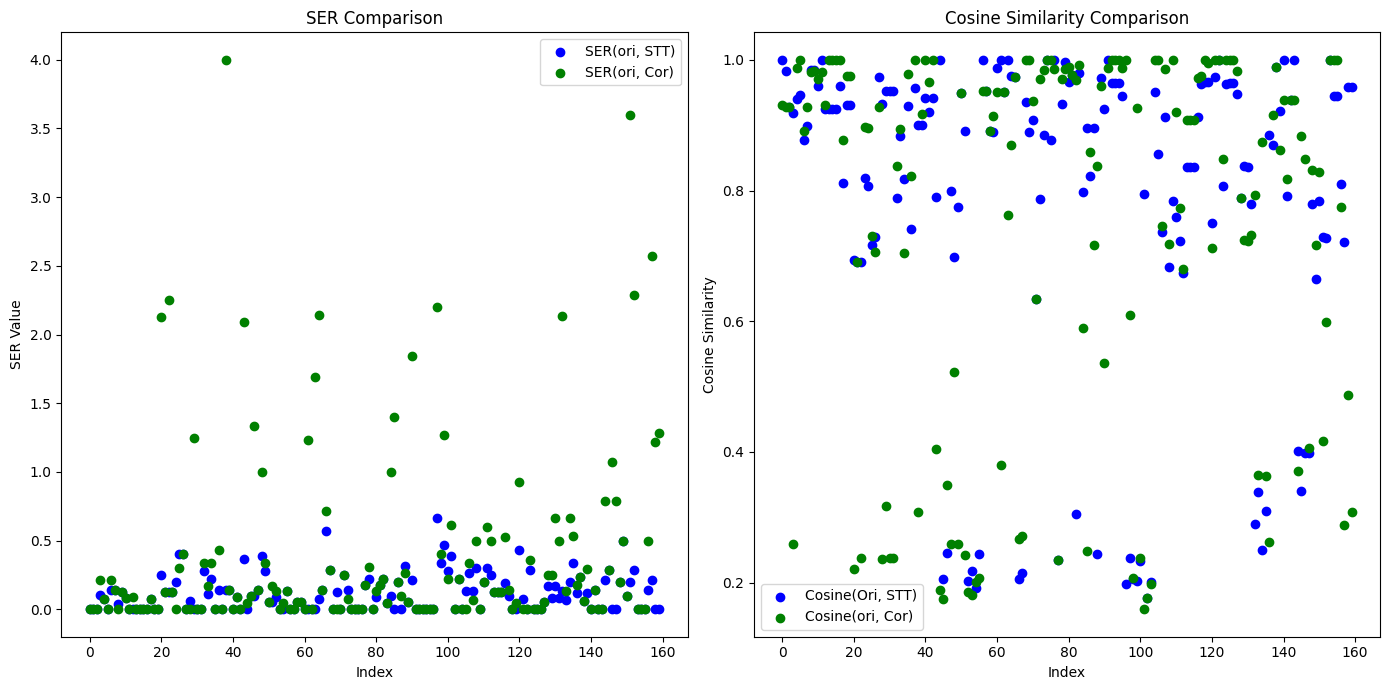

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# 엑셀 파일 경로
file_path = '/content/output_5_16.xlsx'

# 엑셀 파일을 읽어 데이터프레임으로 구성
df = pd.read_excel(file_path)

# 점 그래프 그리기
plt.figure(figsize=(14, 7))

# SER 점 그래프
plt.subplot(1, 2, 1)
plt.scatter(df.index, df['SER(ori, STT)'], label='SER(ori, STT)', color='blue')
plt.scatter(df.index, df['SER(ori, Cor)'], label='SER(ori, Cor)', color='green')
plt.xlabel('Index')
plt.ylabel('SER Value')
plt.title('SER Comparison')
plt.legend()

# Cosine 유사도 점 그래프
plt.subplot(1, 2, 2)
plt.scatter(df.index, df['Cosine(Ori, STT)'], label='Cosine(Ori, STT)', color='blue')
plt.scatter(df.index, df['Cosine(ori, Cor)'], label='Cosine(ori, Cor)', color='green')
plt.xlabel('Index')
plt.ylabel('Cosine Similarity')
plt.title('Cosine Similarity Comparison')
plt.legend()

# 그래프 출력
plt.tight_layout()
plt.show()
